In [8]:
#Import library

import pandas as pd
import numpy as np
import json
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from feature_engine.creation import CyclicalFeatures
from sklearn.model_selection import cross_val_score, cross_validate, KFold


In [23]:
# json file

with open('county_id.json','r') as file:
    county_map = json.load(file)

print(list(county_map.keys())[:])

# train.csv file
df = pd.read_csv('train.csv')
print(df.info())



['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB
None


In [24]:
df.tail()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60
2018351,15,1,3,196.240,1,2023-05-31 23:00:00,637,2018351,60


In [25]:
# set row_id as the index

if df['row_id'].is_unique:
    df.set_index('row_id', drop=True, inplace=True)
else:
    print('row-id is not unique.')

df.reset_index(drop=True, inplace=True)
print(df.head())

   county  is_business  product_type  target  is_consumption  \
0       0            0             1   0.713               0   
1       0            0             1  96.590               1   
2       0            0             2   0.000               0   
3       0            0             2  17.314               1   
4       0            0             3   2.904               0   

              datetime  data_block_id  prediction_unit_id  
0  2021-09-01 00:00:00              0                   0  
1  2021-09-01 00:00:00              0                   0  
2  2021-09-01 00:00:00              0                   1  
3  2021-09-01 00:00:00              0                   1  
4  2021-09-01 00:00:00              0                   2  


In [26]:
# add an county name coulmn
df['county'] = df['county'].astype(str)
county_map = {str(k): v for k, v in county_map.items()}

df['county_name'] = df['county'].map(county_map)
county_map['UNKNOWN'] = 'Unknown'
df.to_csv('updated_data.csv', index=False)

print(df.head())
df['county_name'].isnull().sum()
df['county_name'].isna().sum()
df['county_name'].unique()
df['county'] = df['county'].astype(int)
df['county'].unique()

  county  is_business  product_type  target  is_consumption  \
0      0            0             1   0.713               0   
1      0            0             1  96.590               1   
2      0            0             2   0.000               0   
3      0            0             2  17.314               1   
4      0            0             3   2.904               0   

              datetime  data_block_id  prediction_unit_id county_name  
0  2021-09-01 00:00:00              0                   0    HARJUMAA  
1  2021-09-01 00:00:00              0                   0    HARJUMAA  
2  2021-09-01 00:00:00              0                   1    HARJUMAA  
3  2021-09-01 00:00:00              0                   1    HARJUMAA  
4  2021-09-01 00:00:00              0                   2    HARJUMAA  


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [27]:
# is_business
df['is_business'].dtypes
df['is_business'].unique()


array([0, 1])

In [28]:
# product_type
df['product_type'].dtypes
df['product_type'].isna().sum()
df['product_type'].isnull().sum()
df['product_type'].unique()
contract_types =  {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}
df['product_type'] = df['product_type'].astype(str)
contract_types = {str(k): v for k, v in contract_types.items()}
df['contract_types'] = df['product_type'].map(contract_types)
df['product_type'] = df['product_type'].astype(int)
df['contract_types'].isnull().sum()
df['contract_types'].isna().sum()
df['contract_types'].unique()

array(['Fixed', 'General service', 'Spot', 'Combined'], dtype=object)

In [29]:
# new order
new_order = ['county', 'county_name','is_business', 'product_type','contract_types', 'target', 'is_consumption','datetime', 'data_block_id', 'prediction_unit_id']
df = df[new_order]
df.tail()


,county,county_name,is_business,product_type,contract_types,target,is_consumption,datetime,data_block_id,prediction_unit_id
2018347,15,VÕRUMAA,1,0,Combined,197.233,1,2023-05-31 23:00:00,637,64
2018348,15,VÕRUMAA,1,1,Fixed,0.000,0,2023-05-31 23:00:00,637,59
2018349,15,VÕRUMAA,1,1,Fixed,28.404,1,2023-05-31 23:00:00,637,59
2018350,15,VÕRUMAA,1,3,Spot,0.000,0,2023-05-31 23:00:00,637,60
2018351,15,VÕRUMAA,1,3,Spot,196.240,1,2023-05-31 23:00:00,637,60


In [32]:
# Target
df['target'].dtypes
df['target'].isnull().sum()
df['target'].mean()


274.8555600988986

In [38]:

df['datetime'] = pd.to_datetime(df['datetime'])


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 10 columns):
 #   Column              Dtype         
---  ------              -----         
 0   county              int64         
 1   county_name         object        
 2   is_business         int64         
 3   product_type        int64         
 4   contract_types      object        
 5   target              float64       
 6   is_consumption      int64         
 7   datetime            datetime64[ns]
 8   data_block_id       int64         
 9   prediction_unit_id  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(2)
memory usage: 154.0+ MB


In [44]:
missing_percentage = df.isna().mean() * 100
print("Percentage of missing values in each column:\n", missing_percentage)

Percentage of missing values in each column:
 county                0.00000
county_name           0.00000
is_business           0.00000
product_type          0.00000
contract_types        0.00000
target                0.02616
is_consumption        0.00000
datetime              0.00000
data_block_id         0.00000
prediction_unit_id    0.00000
dtype: float64


In [9]:
# # Try to find missing values using some models but their predicted values are not accuate so I removed the missing valuses

# train_df = df[df['target'].notna()]
# predict_df = df[df['target'].isna()]


# # Calculate percentage of missing values in each column
# missing_percentage = df.isna().mean() * 100
# print("Percentage of missing values in each column:\n", missing_percentage)
# nulls = df.isna()
# rows_with_nulls = nulls.any(axis=1)
# rows_with_na = df[rows_with_nulls]
# print(rows_with_na)
# for index, row in rows_with_na.iterrows():
#     null_columns = row[row.isna()].index
#     print(f"Row {index} has nulls in columns: {list(null_columns)}")


# # Try to deal with missing values

# # Randomforest
# # Selecting features and target
# X_train = train_df[['county','is_business','product_type']]
# y_train = train_df['target']


# # Splitting the training data for model validation
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# # Initialize the model
# model = RandomForestRegressor()

# # Train the model
# model.fit(X_train, y_train)

# # Validate the model
# y_pred = model.predict(X_val)
# print("Validation Mean Squared Error:", mean_squared_error(y_val, y_pred)) 
# # Validation Mean Squared Error: 376444.0277654913 Thus, it is not suitable.

# rmse = mean_squared_error(y_val, y_pred, squared=False)
# print("Validation RMSE:", rmse)  # Validation RMSE: 613.5503465613 Thus, it is not suitable.

# # KNN
# X =  train_df[['county','is_business','product_type']]
# y = train_df['target']
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
# # Initialize the KNN Regressor
# # n_neighbors is a hyperparameter; you can start with 5 and tune it later
# knn = KNeighborsRegressor(n_neighbors=5)

# # Train the model
# knn.fit(X_train, y_train)
# y_pred = knn.predict(X_test)
# y_pred
# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# print("Mean Squared Error:", mse)
# print("Root Mean Squared Error:", rmse)

# param_grid = {'n_neighbors': range(1, 31)}

# random_search = RandomizedSearchCV(KNeighborsRegressor(), param_grid, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# random_search.fit(X_train, y_train)

# print("Best parameters:", random_search.best_params_)
# print("Best cross-validation score (RMSE):", np.sqrt(-random_search.best_score_))
# # Best cross-validation score (RMSE): 615.1979076756409 Thus, not suitable



# # Assuming X and y are your features and target variable
# model = LinearRegression()
# model.fit(X, y)
# y_pred = model.predict(X)

# print("R-squared:", r2_score(y, y_pred))
# print("RMSE:", mean_squared_error(y, y_pred, squared=False))
# # RMSE: 795.5498473874604 Thus, not suitable

# X =  train_df[['county','is_business','product_type']]
# y = train_df['target']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
# gbm.fit(X_train, y_train)

# y_pred = gbm.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Squared Error: {mse}")
# print(f"Root Mean Squared Error: {rmse}")
# print(f"R-squared: {r2}")
# # Root Mean Squared Error: 617.8413389008446 Thus, no



In [45]:
# Since the missing value's percentage is less than 30%, I will remove them
df_cleaned = df.dropna()
df_cleaned.info()
missing_percentage_cleaned = df_cleaned.isna().mean() * 100
print("Percentage of missing values in each column:\n", missing_percentage_cleaned)
df_cleaned['target'].isnull().sum()

# is_consumption
df_cleaned['is_consumption'].unique()

# datetime 
df_cleaned['datetime'].dtypes

# data_block_id
df_cleaned['data_block_id'].dtype

df_cleaned.to_csv('cleaned_train.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2017824 entries, 0 to 2018351
Data columns (total 10 columns):
 #   Column              Dtype         
---  ------              -----         
 0   county              int64         
 1   county_name         object        
 2   is_business         int64         
 3   product_type        int64         
 4   contract_types      object        
 5   target              float64       
 6   is_consumption      int64         
 7   datetime            datetime64[ns]
 8   data_block_id       int64         
 9   prediction_unit_id  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(2)
memory usage: 169.3+ MB
Percentage of missing values in each column:
 county                0.0
county_name           0.0
is_business           0.0
product_type          0.0
contract_types        0.0
target                0.0
is_consumption        0.0
datetime              0.0
data_block_id         0.0
prediction_unit_id    0.0
dtype: float64


In [11]:
# df_cleaned['datetime'] = pd.to_datetime(df_cleaned['datetime'])

df_cleaned['datetime'] = pd.to_datetime(df_cleaned['datetime'])
df_cleaned['datetime'] = df_cleaned['datetime'].dt.strftime('%Y-%m-%d')
df_cleaned.info()


/var/folders/_k/1s8z0gzs6_l2cpc1gxrlwq6w0000gn/T/ipykernel_37662/820560370.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['datetime'] = pd.to_datetime(df_cleaned['datetime'])
/var/folders/_k/1s8z0gzs6_l2cpc1gxrlwq6w0000gn/T/ipykernel_37662/820560370.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['datetime'] = df_cleaned['datetime'].dt.strftime('%Y-%m-%d')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048315 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   county              1048315 non-null  int64  
 1   county_name         1048315 non-null  object 
 2   is_business         1048315 non-null  int64  
 3   product_type        1048315 non-null  int64  
 4   contract_types      1048315 non-null  object 
 5   target              1048315 non-null  float64
 6   is_consumption      1048315 non-null  int64  
 7   datetime            1048315 non-null  object 
 8   data_block_id       1048315 non-null  int64  
 9   prediction_unit_id  1048315 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 88.0+ MB


# Combine two data

In [47]:
# electricity_prices

e_df = pd.read_csv('electricity_prices.csv')
e_df.info()
e_df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   forecast_date  15286 non-null  object 
 1   euros_per_mwh  15286 non-null  float64
 2   origin_date    15286 non-null  object 
 3   data_block_id  15286 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 477.8+ KB


forecast_date    0
euros_per_mwh    0
origin_date      0
data_block_id    0
dtype: int64

In [48]:
# merge
# inner join only keep rows with matching 'data_block_id' in both DataFrame
combined_df = pd.merge(df_cleaned,e_df, on = 'data_block_id', how = 'inner')

In [49]:
print(combined_df.info())
print(combined_df.isnull().sum())
print(combined_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48351072 entries, 0 to 48351071
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   county              int64         
 1   county_name         object        
 2   is_business         int64         
 3   product_type        int64         
 4   contract_types      object        
 5   target              float64       
 6   is_consumption      int64         
 7   datetime            datetime64[ns]
 8   data_block_id       int64         
 9   prediction_unit_id  int64         
 10  forecast_date       object        
 11  euros_per_mwh       float64       
 12  origin_date         object        
dtypes: datetime64[ns](1), float64(2), int64(6), object(4)
memory usage: 5.0+ GB
None
county                0
county_name           0
is_business           0
product_type          0
contract_types        0
target                0
is_consumption        0
datetime              0
data_bl

In [50]:
print(combined_df['datetime'])

0          2021-09-02 00:00:00
1          2021-09-02 00:00:00
2          2021-09-02 00:00:00
3          2021-09-02 00:00:00
4          2021-09-02 00:00:00
                   ...        
48351067   2023-05-31 23:00:00
48351068   2023-05-31 23:00:00
48351069   2023-05-31 23:00:00
48351070   2023-05-31 23:00:00
48351071   2023-05-31 23:00:00
Name: datetime, Length: 48351072, dtype: datetime64[ns]


In [51]:
# Duplicated 

duplicates_all = combined_df.duplicated(keep=False)
print(combined_df[duplicates_all])

# Mark duplicates based on specific columns
duplicates = combined_df.duplicated(subset=['county', 'is_business', 'product_type','target','is_consumption'], keep=False)

# Display the duplicated rows
print(combined_df[duplicates])


Empty DataFrame
Columns: [county, county_name, is_business, product_type, contract_types, target, is_consumption, datetime, data_block_id, prediction_unit_id, forecast_date, euros_per_mwh, origin_date]
Index: []
          county county_name  is_business  product_type contract_types  \
0              0    HARJUMAA            0             1          Fixed   
1              0    HARJUMAA            0             1          Fixed   
2              0    HARJUMAA            0             1          Fixed   
3              0    HARJUMAA            0             1          Fixed   
4              0    HARJUMAA            0             1          Fixed   
...          ...         ...          ...           ...            ...   
48351067      15     VÕRUMAA            1             3           Spot   
48351068      15     VÕRUMAA            1             3           Spot   
48351069      15     VÕRUMAA            1             3           Spot   
48351070      15     VÕRUMAA            1       

In [52]:
num_duplicates_all = combined_df.duplicated(keep=False).sum()
print("Number of duplicate rows (all columns):", num_duplicates_all)

num_duplicates_specific = combined_df.duplicated(subset=['county', 'is_business', 'product_type','target','is_consumption'], keep=False).sum()
print("Number of duplicate rows (specific column):", num_duplicates_specific)


Number of duplicate rows (all columns): 0
Number of duplicate rows (specific column): 48351072


In [53]:
combined_df_cleaned = combined_df.drop_duplicates(subset=['county', 'is_business', 'product_type', 'target', 'is_consumption'], keep='first')

In [54]:
combined_df_cleaned

,county,county_name,is_business,product_type,contract_types,target,is_consumption,datetime,data_block_id,prediction_unit_id,forecast_date,euros_per_mwh,origin_date
0,0,HARJUMAA,0,1,Fixed,1.687,0,2021-09-02 00:00:00,1,0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00
24,0,HARJUMAA,0,1,Fixed,109.366,1,2021-09-02 00:00:00,1,0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00
48,0,HARJUMAA,0,2,General service,0.000,0,2021-09-02 00:00:00,1,1,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00
72,0,HARJUMAA,0,2,General service,21.008,1,2021-09-02 00:00:00,1,1,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00
96,0,HARJUMAA,0,3,Spot,1.003,0,2021-09-02 00:00:00,1,2,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48350856,15,VÕRUMAA,0,1,Fixed,42.401,1,2023-05-31 23:00:00,637,57,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00
48350904,15,VÕRUMAA,0,3,Spot,117.332,1,2023-05-31 23:00:00,637,58,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00
48350952,15,VÕRUMAA,1,0,Combined,197.233,1,2023-05-31 23:00:00,637,64,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00
48351000,15,VÕRUMAA,1,1,Fixed,28.404,1,2023-05-31 23:00:00,637,59,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00


# Combine Gas

In [55]:
# gas_prices

g_df = pd.read_csv('gas_prices.csv')
print(g_df.isnull().sum())
g_df.info()

forecast_date            0
lowest_price_per_mwh     0
highest_price_per_mwh    0
origin_date              0
data_block_id            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   forecast_date          637 non-null    object 
 1   lowest_price_per_mwh   637 non-null    float64
 2   highest_price_per_mwh  637 non-null    float64
 3   origin_date            637 non-null    object 
 4   data_block_id          637 non-null    int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 25.0+ KB


In [56]:
# add gas_prices
combined_df_1 = pd.merge(combined_df_cleaned,g_df, on = 'data_block_id', how = 'inner')
print(combined_df_1.info())
print(combined_df_1.isnull().sum())
print(combined_df_1.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1401742 entries, 0 to 1401741
Data columns (total 17 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   county                 1401742 non-null  int64         
 1   county_name            1401742 non-null  object        
 2   is_business            1401742 non-null  int64         
 3   product_type           1401742 non-null  int64         
 4   contract_types         1401742 non-null  object        
 5   target                 1401742 non-null  float64       
 6   is_consumption         1401742 non-null  int64         
 7   datetime               1401742 non-null  datetime64[ns]
 8   data_block_id          1401742 non-null  int64         
 9   prediction_unit_id     1401742 non-null  int64         
 10  forecast_date_x        1401742 non-null  object        
 11  euros_per_mwh          1401742 non-null  float64       
 12  origin_date_x          14017

In [57]:
combined_df_1

,county,county_name,is_business,product_type,contract_types,target,is_consumption,datetime,data_block_id,prediction_unit_id,forecast_date_x,euros_per_mwh,origin_date_x,forecast_date_y,lowest_price_per_mwh,highest_price_per_mwh,origin_date_y
0,0,HARJUMAA,0,1,Fixed,1.687,0,2021-09-02 00:00:00,1,0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,2021-09-01,45.23,46.32,2021-08-31
1,0,HARJUMAA,0,1,Fixed,109.366,1,2021-09-02 00:00:00,1,0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,2021-09-01,45.23,46.32,2021-08-31
2,0,HARJUMAA,0,2,General service,0.000,0,2021-09-02 00:00:00,1,1,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,2021-09-01,45.23,46.32,2021-08-31
3,0,HARJUMAA,0,2,General service,21.008,1,2021-09-02 00:00:00,1,1,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,2021-09-01,45.23,46.32,2021-08-31
4,0,HARJUMAA,0,3,Spot,1.003,0,2021-09-02 00:00:00,1,2,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,2021-09-01,45.23,46.32,2021-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401737,15,VÕRUMAA,0,1,Fixed,42.401,1,2023-05-31 23:00:00,637,57,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,2023-05-30,29.00,34.00,2023-05-29
1401738,15,VÕRUMAA,0,3,Spot,117.332,1,2023-05-31 23:00:00,637,58,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,2023-05-30,29.00,34.00,2023-05-29
1401739,15,VÕRUMAA,1,0,Combined,197.233,1,2023-05-31 23:00:00,637,64,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,2023-05-30,29.00,34.00,2023-05-29
1401740,15,VÕRUMAA,1,1,Fixed,28.404,1,2023-05-31 23:00:00,637,59,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,2023-05-30,29.00,34.00,2023-05-29


In [58]:
# Drop the columns 

df_dropped = combined_df_1.drop(['forecast_date_y', 'origin_date_y'], axis=1)

In [59]:
df_dropped

,county,county_name,is_business,product_type,contract_types,target,is_consumption,datetime,data_block_id,prediction_unit_id,forecast_date_x,euros_per_mwh,origin_date_x,lowest_price_per_mwh,highest_price_per_mwh
0,0,HARJUMAA,0,1,Fixed,1.687,0,2021-09-02 00:00:00,1,0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,45.23,46.32
1,0,HARJUMAA,0,1,Fixed,109.366,1,2021-09-02 00:00:00,1,0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,45.23,46.32
2,0,HARJUMAA,0,2,General service,0.000,0,2021-09-02 00:00:00,1,1,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,45.23,46.32
3,0,HARJUMAA,0,2,General service,21.008,1,2021-09-02 00:00:00,1,1,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,45.23,46.32
4,0,HARJUMAA,0,3,Spot,1.003,0,2021-09-02 00:00:00,1,2,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,45.23,46.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401737,15,VÕRUMAA,0,1,Fixed,42.401,1,2023-05-31 23:00:00,637,57,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.00,34.00
1401738,15,VÕRUMAA,0,3,Spot,117.332,1,2023-05-31 23:00:00,637,58,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.00,34.00
1401739,15,VÕRUMAA,1,0,Combined,197.233,1,2023-05-31 23:00:00,637,64,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.00,34.00
1401740,15,VÕRUMAA,1,1,Fixed,28.404,1,2023-05-31 23:00:00,637,59,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.00,34.00


In [60]:
# Duplicated_g

duplicates_all_g = df_dropped.duplicated(keep=False)
print(df_dropped[duplicates_all_g])

# Mark duplicates based on specific columns
duplicates_g = df_dropped.duplicated(subset=['county', 'is_business', 'product_type','target','is_consumption'], keep=False)

# Display the duplicated rows
print(df_dropped[duplicates_g])


Empty DataFrame
Columns: [county, county_name, is_business, product_type, contract_types, target, is_consumption, datetime, data_block_id, prediction_unit_id, forecast_date_x, euros_per_mwh, origin_date_x, lowest_price_per_mwh, highest_price_per_mwh]
Index: []
Empty DataFrame
Columns: [county, county_name, is_business, product_type, contract_types, target, is_consumption, datetime, data_block_id, prediction_unit_id, forecast_date_x, euros_per_mwh, origin_date_x, lowest_price_per_mwh, highest_price_per_mwh]
Index: []


In [61]:
df_dropped[duplicates_g]

,county,county_name,is_business,product_type,contract_types,target,is_consumption,datetime,data_block_id,prediction_unit_id,forecast_date_x,euros_per_mwh,origin_date_x,lowest_price_per_mwh,highest_price_per_mwh


In [62]:
combined_g_e_cleaned = df_dropped.drop_duplicates(subset=['county', 'is_business', 'product_type', 'target', 'is_consumption'], keep='first')

In [63]:
combined_g_e_cleaned

,county,county_name,is_business,product_type,contract_types,target,is_consumption,datetime,data_block_id,prediction_unit_id,forecast_date_x,euros_per_mwh,origin_date_x,lowest_price_per_mwh,highest_price_per_mwh
0,0,HARJUMAA,0,1,Fixed,1.687,0,2021-09-02 00:00:00,1,0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,45.23,46.32
1,0,HARJUMAA,0,1,Fixed,109.366,1,2021-09-02 00:00:00,1,0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,45.23,46.32
2,0,HARJUMAA,0,2,General service,0.000,0,2021-09-02 00:00:00,1,1,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,45.23,46.32
3,0,HARJUMAA,0,2,General service,21.008,1,2021-09-02 00:00:00,1,1,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,45.23,46.32
4,0,HARJUMAA,0,3,Spot,1.003,0,2021-09-02 00:00:00,1,2,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,45.23,46.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401737,15,VÕRUMAA,0,1,Fixed,42.401,1,2023-05-31 23:00:00,637,57,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.00,34.00
1401738,15,VÕRUMAA,0,3,Spot,117.332,1,2023-05-31 23:00:00,637,58,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.00,34.00
1401739,15,VÕRUMAA,1,0,Combined,197.233,1,2023-05-31 23:00:00,637,64,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.00,34.00
1401740,15,VÕRUMAA,1,1,Fixed,28.404,1,2023-05-31 23:00:00,637,59,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.00,34.00


In [64]:
combined_g_e_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1401742 entries, 0 to 1401741
Data columns (total 15 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   county                 1401742 non-null  int64         
 1   county_name            1401742 non-null  object        
 2   is_business            1401742 non-null  int64         
 3   product_type           1401742 non-null  int64         
 4   contract_types         1401742 non-null  object        
 5   target                 1401742 non-null  float64       
 6   is_consumption         1401742 non-null  int64         
 7   datetime               1401742 non-null  datetime64[ns]
 8   data_block_id          1401742 non-null  int64         
 9   prediction_unit_id     1401742 non-null  int64         
 10  forecast_date_x        1401742 non-null  object        
 11  euros_per_mwh          1401742 non-null  float64       
 12  origin_date_x          14017

# combine historical_weather

In [65]:
w_df = pd.read_csv('historical_weather.csv')

In [66]:
w_df.info()
w_df['data_block_id'] = w_df['data_block_id'].astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710802 entries, 0 to 1710801
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   datetime                object 
 1   temperature             float64
 2   dewpoint                float64
 3   rain                    float64
 4   snowfall                float64
 5   surface_pressure        float64
 6   cloudcover_total        int64  
 7   cloudcover_low          int64  
 8   cloudcover_mid          int64  
 9   cloudcover_high         int64  
 10  windspeed_10m           float64
 11  winddirection_10m       int64  
 12  shortwave_radiation     float64
 13  direct_solar_radiation  float64
 14  diffuse_radiation       float64
 15  latitude                float64
 16  longitude               float64
 17  data_block_id           float64
dtypes: float64(12), int64(5), object(1)
memory usage: 234.9+ MB


In [68]:
w_c_df = pd.read_excel('weather_station_to_county_mapping.xlsx')
w_c_df

,county_name,longitude,latitude,county
0,NaN,21.7,57.6,NaN
1,NaN,21.7,57.9,NaN
2,NaN,21.7,58.2,NaN
3,NaN,21.7,58.5,NaN
4,NaN,21.7,58.8,NaN
...,...,...,...,...
107,NaN,28.2,58.5,NaN
108,NaN,28.2,58.8,NaN
109,NaN,28.2,59.1,NaN
110,NaN,28.2,59.4,NaN


In [69]:
filtered_w_c_df = w_c_df.dropna()
filtered_w_c_df['county'] = filtered_w_c_df['county'].astype(int)

/var/folders/_k/1s8z0gzs6_l2cpc1gxrlwq6w0000gn/T/ipykernel_48751/1508724395.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_w_c_df['county'] = filtered_w_c_df['county'].astype(int)


In [70]:
print(filtered_w_c_df.info())
print(filtered_w_c_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 10 to 102
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   county_name  49 non-null     object 
 1   longitude    49 non-null     float64
 2   latitude     49 non-null     float64
 3   county       49 non-null     int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 1.9+ KB
None
         county_name  longitude  latitude  county
10          Saaremaa       22.2      58.2      10
11          Saaremaa       22.2      58.5      10
19          Saaremaa       22.7      58.5      10
20           Hiiumaa       22.7      58.8       1
27          Saaremaa       23.2      58.5      10
35         PÃ¤rnumaa       23.7      58.5       7
36        LÃ¤Ã¤nemaa       23.7      58.8       6
37        LÃ¤Ã¤nemaa       23.7      59.1       6
43         PÃ¤rnumaa       24.2      58.5       7
44          Raplamaa       24.2      58.8       9
45          Harjumaa       

In [72]:
merged_w_c_df = pd.merge(w_df,filtered_w_c_df, on=['latitude', 'longitude'],how ='inner')

In [73]:
merged_w_c_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198575 entries, 0 to 198574
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   datetime                198575 non-null  object 
 1   temperature             198575 non-null  float64
 2   dewpoint                198575 non-null  float64
 3   rain                    198575 non-null  float64
 4   snowfall                198575 non-null  float64
 5   surface_pressure        198575 non-null  float64
 6   cloudcover_total        198575 non-null  int64  
 7   cloudcover_low          198575 non-null  int64  
 8   cloudcover_mid          198575 non-null  int64  
 9   cloudcover_high         198575 non-null  int64  
 10  windspeed_10m           198575 non-null  float64
 11  winddirection_10m       198575 non-null  int64  
 12  shortwave_radiation     198575 non-null  float64
 13  direct_solar_radiation  198575 non-null  float64
 14  diffuse_radiation   

In [74]:
combined_g_e_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1401742 entries, 0 to 1401741
Data columns (total 15 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   county                 1401742 non-null  int64         
 1   county_name            1401742 non-null  object        
 2   is_business            1401742 non-null  int64         
 3   product_type           1401742 non-null  int64         
 4   contract_types         1401742 non-null  object        
 5   target                 1401742 non-null  float64       
 6   is_consumption         1401742 non-null  int64         
 7   datetime               1401742 non-null  datetime64[ns]
 8   data_block_id          1401742 non-null  int64         
 9   prediction_unit_id     1401742 non-null  int64         
 10  forecast_date_x        1401742 non-null  object        
 11  euros_per_mwh          1401742 non-null  float64       
 12  origin_date_x          14017

In [75]:
merged_w_c_df['datetime'] = pd.to_datetime(merged_w_c_df['datetime'])
combined_g_e_cleaned['datetime'] = pd.to_datetime(combined_g_e_cleaned['datetime'])


In [76]:
print(merged_w_c_df['datetime'])
print(combined_g_e_cleaned['datetime'])

0        2021-09-01 00:00:00
1        2021-09-01 01:00:00
2        2021-09-01 02:00:00
3        2021-09-01 03:00:00
4        2021-09-01 04:00:00
                 ...        
198570   2023-05-30 06:00:00
198571   2023-05-30 07:00:00
198572   2023-05-30 08:00:00
198573   2023-05-30 09:00:00
198574   2023-05-30 10:00:00
Name: datetime, Length: 198575, dtype: datetime64[ns]
0         2021-09-02 00:00:00
1         2021-09-02 00:00:00
2         2021-09-02 00:00:00
3         2021-09-02 00:00:00
4         2021-09-02 00:00:00
                  ...        
1401737   2023-05-31 23:00:00
1401738   2023-05-31 23:00:00
1401739   2023-05-31 23:00:00
1401740   2023-05-31 23:00:00
1401741   2023-05-31 23:00:00
Name: datetime, Length: 1401742, dtype: datetime64[ns]


In [77]:
merged_df_2 = pd.merge(merged_w_c_df, combined_g_e_cleaned, on=['data_block_id', 'county'], how='inner')


In [78]:
print(merged_df_2.columns.tolist())

['datetime_x', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 'windspeed_10m', 'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation', 'latitude', 'longitude', 'data_block_id', 'county_name_x', 'county', 'county_name_y', 'is_business', 'product_type', 'contract_types', 'target', 'is_consumption', 'datetime_y', 'prediction_unit_id', 'forecast_date_x', 'euros_per_mwh', 'origin_date_x', 'lowest_price_per_mwh', 'highest_price_per_mwh']


In [79]:

# Specify the new order of columns
new_column_order = [
    'datetime_x', 'county_name_y', 'data_block_id', 'latitude', 'longitude',
    'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 
    'cloudcover_total', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 
    'windspeed_10m', 'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation', 
    'diffuse_radiation', 'county', 'is_business', 'product_type', 'contract_types', 
    'target', 'is_consumption', 'prediction_unit_id', 'forecast_date_x', 'euros_per_mwh', 
    'origin_date_x', 'lowest_price_per_mwh', 'highest_price_per_mwh', 'county_name_x', 'datetime_y'
]

# Reorder the DataFrame
merged_df_2 = merged_df_2[new_column_order]

# Assuming your DataFrame is named df
merged_df_2 = merged_df_2.rename(columns={'datetime_x': 'datetime','forecast_date_x': 'forecast_date', 'origin_date_x': 'origin_date'\
                                          ,'county_name_y':'county_name', 'lowest_price_per_mwh': 'lowest_price_per_mwh(gas)'\
                                            ,'highest_price_per_mwh':'highest_price_per_mwh(gas)'})


In [80]:
merged_df_g_e_w_c = merged_df_2.drop(columns='datetime_y')

In [81]:
merged_df_g_e_w_c.drop(columns='county_name_x',inplace = True)

In [82]:
merged_df_g_e_w_c

,datetime,county_name,data_block_id,latitude,longitude,temperature,dewpoint,rain,snowfall,surface_pressure,...,product_type,contract_types,target,is_consumption,prediction_unit_id,forecast_date,euros_per_mwh,origin_date,lowest_price_per_mwh,highest_price_per_mwh
0,2021-09-01 00:00:00,VÕRUMAA,1,57.6,26.7,13.0,11.5,0.0,0.0,998.5,...,1,Fixed,0.550,0,57,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,45.23,46.32
1,2021-09-01 00:00:00,VÕRUMAA,1,57.6,26.7,13.0,11.5,0.0,0.0,998.5,...,1,Fixed,5.717,1,57,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,45.23,46.32
2,2021-09-01 00:00:00,VÕRUMAA,1,57.6,26.7,13.0,11.5,0.0,0.0,998.5,...,3,Spot,3.984,0,58,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,45.23,46.32
3,2021-09-01 00:00:00,VÕRUMAA,1,57.6,26.7,13.0,11.5,0.0,0.0,998.5,...,3,Spot,68.130,1,58,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,45.23,46.32
4,2021-09-01 00:00:00,VÕRUMAA,1,57.6,26.7,13.0,11.5,0.0,0.0,998.5,...,1,Fixed,0.100,0,59,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,45.23,46.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33175009,2023-05-30 10:00:00,PÕLVAMAA,637,58.2,27.2,13.8,3.1,0.0,0.0,1015.0,...,3,Spot,83.942,1,32,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.00,34.00
33175010,2023-05-30 10:00:00,PÕLVAMAA,637,58.2,27.2,13.8,3.1,0.0,0.0,1015.0,...,3,Spot,491.211,1,33,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.00,34.00
33175011,2023-05-30 10:00:00,PÕLVAMAA,637,58.2,27.2,13.8,3.1,0.0,0.0,1015.0,...,1,Fixed,21.983,1,31,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.00,34.00
33175012,2023-05-30 10:00:00,PÕLVAMAA,637,58.2,27.2,13.8,3.1,0.0,0.0,1015.0,...,3,Spot,66.760,1,32,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.00,34.00


In [83]:
merged_df_g_e_w_c
merged_df_g_e_w_c_1 = merged_df_g_e_w_c.drop_duplicates(subset=['county', 'is_business', 'product_type', 'target', 'is_consumption'], keep='first')

In [84]:
merged_df_g_e_w_c_1.to_csv('cleaned_train_.csv', index=False)



In [85]:
df1 = pd.read_csv('cleaned_train_.csv')

In [86]:
df1.tail()

,datetime,county_name,data_block_id,latitude,longitude,temperature,dewpoint,rain,snowfall,surface_pressure,...,product_type,contract_types,target,is_consumption,prediction_unit_id,forecast_date,euros_per_mwh,origin_date,lowest_price_per_mwh,highest_price_per_mwh
698421,2023-05-29 11:00:00,PÕLVAMAA,637,58.2,27.2,15.8,8.0,0.1,0.0,1013.2,...,3,Spot,83.942,1,32,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.0,34.0
698422,2023-05-29 11:00:00,PÕLVAMAA,637,58.2,27.2,15.8,8.0,0.1,0.0,1013.2,...,3,Spot,491.211,1,33,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.0,34.0
698423,2023-05-29 11:00:00,PÕLVAMAA,637,58.2,27.2,15.8,8.0,0.1,0.0,1013.2,...,1,Fixed,21.983,1,31,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.0,34.0
698424,2023-05-29 11:00:00,PÕLVAMAA,637,58.2,27.2,15.8,8.0,0.1,0.0,1013.2,...,3,Spot,66.760,1,32,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.0,34.0
698425,2023-05-29 11:00:00,PÕLVAMAA,637,58.2,27.2,15.8,8.0,0.1,0.0,1013.2,...,3,Spot,471.771,1,33,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.0,34.0


In [87]:
df1.isnull().sum()

datetime                  0
county_name               0
data_block_id             0
latitude                  0
longitude                 0
temperature               0
dewpoint                  0
rain                      0
snowfall                  0
surface_pressure          0
cloudcover_total          0
cloudcover_low            0
cloudcover_mid            0
cloudcover_high           0
windspeed_10m             0
winddirection_10m         0
shortwave_radiation       0
direct_solar_radiation    0
diffuse_radiation         0
county                    0
is_business               0
product_type              0
contract_types            0
target                    0
is_consumption            0
prediction_unit_id        0
forecast_date             0
euros_per_mwh             0
origin_date               0
lowest_price_per_mwh      0
highest_price_per_mwh     0
dtype: int64

In [88]:
df1['data_block_id'].tail()

698421    637
698422    637
698423    637
698424    637
698425    637
Name: data_block_id, dtype: int64

[Text(0.5, 1.0, 'Prices per MWh'),
 Text(0, 0.5, 'lowest_highest_price_per_mwh')]

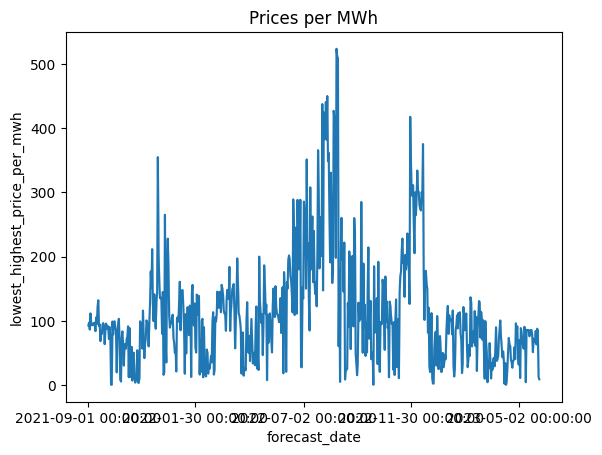

In [89]:
ax = sns.lineplot(data = df1, x = 'forecast_date', y = 'euros_per_mwh')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
ax.set(title = "Prices per MWh", ylabel = 'lowest_highest_price_per_mwh')

In [90]:
# Client 

df_c = pd.read_csv('client.csv')

In [91]:
df_c

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2
...,...,...,...,...,...,...,...
41914,1,15,51,415.60,0,2023-05-29,637
41915,3,15,161,2035.75,0,2023-05-29,637
41916,0,15,15,620.00,1,2023-05-29,637
41917,1,15,20,624.50,1,2023-05-29,637


In [92]:
df3 = pd.merge(df1,df_c, on= ['data_block_id','product_type','county','is_business'], how= 'inner')

In [93]:
df3

,datetime,county_name,data_block_id,latitude,longitude,temperature,dewpoint,rain,snowfall,surface_pressure,...,is_consumption,prediction_unit_id,forecast_date,euros_per_mwh,origin_date,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity,date
0,2021-09-01 11:00:00,VÕRUMAA,2,57.6,26.7,15.4,9.7,0.0,0.0,997.7,...,0,57,2021-09-02 00:00:00,96.99,2021-09-01 00:00:00,45.62,46.29,10,83.2,2021-09-01
1,2021-09-01 11:00:00,VÕRUMAA,2,57.6,26.7,15.4,9.7,0.0,0.0,997.7,...,1,57,2021-09-02 00:00:00,96.99,2021-09-01 00:00:00,45.62,46.29,10,83.2,2021-09-01
2,2021-09-01 11:00:00,VÕRUMAA,2,57.6,26.7,15.4,9.7,0.0,0.0,997.7,...,1,57,2021-09-02 00:00:00,96.99,2021-09-01 00:00:00,45.62,46.29,10,83.2,2021-09-01
3,2021-09-01 11:00:00,VÕRUMAA,2,57.6,26.7,15.4,9.7,0.0,0.0,997.7,...,0,57,2021-09-02 00:00:00,96.99,2021-09-01 00:00:00,45.62,46.29,10,83.2,2021-09-01
4,2021-09-01 11:00:00,VÕRUMAA,2,57.6,26.7,15.4,9.7,0.0,0.0,997.7,...,1,57,2021-09-02 00:00:00,96.99,2021-09-01 00:00:00,45.62,46.29,10,83.2,2021-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695874,2023-05-29 11:00:00,PÕLVAMAA,637,58.2,27.2,15.8,8.0,0.1,0.0,1013.2,...,1,33,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.00,34.00,70,3128.2,2023-05-29
695875,2023-05-29 11:00:00,PÕLVAMAA,637,58.2,27.2,15.8,8.0,0.1,0.0,1013.2,...,0,33,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.00,34.00,70,3128.2,2023-05-29
695876,2023-05-29 11:00:00,PÕLVAMAA,637,58.2,27.2,15.8,8.0,0.1,0.0,1013.2,...,1,33,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.00,34.00,70,3128.2,2023-05-29
695877,2023-05-29 11:00:00,PÕLVAMAA,637,58.2,27.2,15.8,8.0,0.1,0.0,1013.2,...,1,33,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.00,34.00,70,3128.2,2023-05-29


In [94]:
combined_cleaned1 = df3.drop_duplicates(subset=['county', 'is_business', 'product_type', 'target', 'is_consumption'], keep='first')

In [95]:
combined_cleaned1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 695879 entries, 0 to 695878
Data columns (total 34 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   datetime                695879 non-null  object 
 1   county_name             695879 non-null  object 
 2   data_block_id           695879 non-null  int64  
 3   latitude                695879 non-null  float64
 4   longitude               695879 non-null  float64
 5   temperature             695879 non-null  float64
 6   dewpoint                695879 non-null  float64
 7   rain                    695879 non-null  float64
 8   snowfall                695879 non-null  float64
 9   surface_pressure        695879 non-null  float64
 10  cloudcover_total        695879 non-null  int64  
 11  cloudcover_low          695879 non-null  int64  
 12  cloudcover_mid          695879 non-null  int64  
 13  cloudcover_high         695879 non-null  int64  
 14  windspeed_10m       

In [96]:
combined_cleaned1.to_csv('cleaned_train_final.csv', index=False)

In [3]:
df_final = pd.read_csv('cleaned_train_final.csv')

In [4]:
df_final

,datetime,county_name,data_block_id,latitude,longitude,temperature,dewpoint,rain,snowfall,surface_pressure,...,is_consumption,prediction_unit_id,forecast_date,euros_per_mwh,origin_date,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity,date
0,2021-09-01 11:00:00,VÕRUMAA,2,57.6,26.7,15.4,9.7,0.0,0.0,997.7,...,0,57,2021-09-02 00:00:00,96.99,2021-09-01 00:00:00,45.62,46.29,10,83.2,2021-09-01
1,2021-09-01 11:00:00,VÕRUMAA,2,57.6,26.7,15.4,9.7,0.0,0.0,997.7,...,1,57,2021-09-02 00:00:00,96.99,2021-09-01 00:00:00,45.62,46.29,10,83.2,2021-09-01
2,2021-09-01 11:00:00,VÕRUMAA,2,57.6,26.7,15.4,9.7,0.0,0.0,997.7,...,1,57,2021-09-02 00:00:00,96.99,2021-09-01 00:00:00,45.62,46.29,10,83.2,2021-09-01
3,2021-09-01 11:00:00,VÕRUMAA,2,57.6,26.7,15.4,9.7,0.0,0.0,997.7,...,0,57,2021-09-02 00:00:00,96.99,2021-09-01 00:00:00,45.62,46.29,10,83.2,2021-09-01
4,2021-09-01 11:00:00,VÕRUMAA,2,57.6,26.7,15.4,9.7,0.0,0.0,997.7,...,1,57,2021-09-02 00:00:00,96.99,2021-09-01 00:00:00,45.62,46.29,10,83.2,2021-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695874,2023-05-29 11:00:00,PÕLVAMAA,637,58.2,27.2,15.8,8.0,0.1,0.0,1013.2,...,1,33,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.00,34.00,70,3128.2,2023-05-29
695875,2023-05-29 11:00:00,PÕLVAMAA,637,58.2,27.2,15.8,8.0,0.1,0.0,1013.2,...,0,33,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.00,34.00,70,3128.2,2023-05-29
695876,2023-05-29 11:00:00,PÕLVAMAA,637,58.2,27.2,15.8,8.0,0.1,0.0,1013.2,...,1,33,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.00,34.00,70,3128.2,2023-05-29
695877,2023-05-29 11:00:00,PÕLVAMAA,637,58.2,27.2,15.8,8.0,0.1,0.0,1013.2,...,1,33,2023-05-30 00:00:00,8.57,2023-05-29 00:00:00,29.00,34.00,70,3128.2,2023-05-29


In [4]:
print(df_final.columns.tolist())

# ['datetime', 'county_name', 'data_block_id', 'latitude', 'longitude', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 'windspeed_10m', 'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation', 'county', 'is_business', 'product_type', 'contract_types', 'target', 'is_consumption', 'prediction_unit_id', 'forecast_date', 'euros_per_mwh', 'origin_date', 'lowest_price_per_mwh', 'highest_price_per_mwh', 'eic_count', 'installed_capacity', 'date']

['datetime', 'county_name', 'data_block_id', 'latitude', 'longitude', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 'windspeed_10m', 'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation', 'county', 'is_business', 'product_type', 'contract_types', 'target', 'is_consumption', 'prediction_unit_id', 'forecast_date', 'euros_per_mwh', 'origin_date', 'lowest_price_per_mwh', 'highest_price_per_mwh', 'eic_count', 'installed_capacity', 'date']


In [5]:
df_final.drop(columns=['date','forecast_date','origin_date'], inplace=True)

In [7]:
print(df_final.columns.tolist())

['datetime', 'county_name', 'data_block_id', 'latitude', 'longitude', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 'windspeed_10m', 'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation', 'county', 'is_business', 'product_type', 'contract_types', 'target', 'is_consumption', 'prediction_unit_id', 'euros_per_mwh', 'lowest_price_per_mwh', 'highest_price_per_mwh', 'eic_count', 'installed_capacity']


In [10]:
df_final.describe()

,data_block_id,latitude,longitude,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,...,is_business,product_type,target,is_consumption,prediction_unit_id,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity
count,695879.000000,695879.000000,695879.000000,695879.000000,695879.000000,695879.000000,695879.000000,695879.000000,695879.000000,695879.000000,...,695879.000000,695879.000000,695879.000000,695879.000000,695879.000000,695879.000000,695879.000000,695879.000000,695879.000000,695879.000000
mean,321.225325,58.073911,25.482724,7.481505,2.564524,0.053320,0.013056,1006.262100,63.756275,49.478093,...,0.529233,1.937439,336.547828,0.666620,45.253010,114.621462,96.480461,109.312702,69.872458,1462.858564
std,181.492578,0.222325,1.505715,8.792649,7.421110,0.187113,0.058096,12.658365,36.166766,39.549800,...,0.499145,1.076974,781.186767,0.471421,11.869278,88.224900,48.869419,56.210033,89.387708,1600.595168
min,2.000000,57.600000,22.200000,-21.600000,-23.900000,0.000000,0.000000,953.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,25.000000,0.010000,28.100000,34.000000,5.000000,6.000000
25%,177.000000,57.900000,24.700000,0.700000,-2.400000,0.000000,0.000000,999.000000,31.000000,7.000000,...,0.000000,1.000000,21.280000,0.000000,33.000000,57.080000,59.000000,67.180000,15.000000,437.600000
50%,316.000000,58.200000,26.200000,7.700000,2.400000,0.000000,0.000000,1007.200000,76.000000,47.000000,...,1.000000,2.000000,89.261000,1.000000,46.000000,96.310000,86.830000,98.000000,43.000000,967.200000
75%,475.000000,58.200000,26.200000,13.200000,7.700000,0.000000,0.000000,1014.500000,100.000000,94.000000,...,1.000000,3.000000,313.897000,1.000000,55.000000,144.280000,110.050000,134.780000,83.000000,1848.200000
max,637.000000,58.200000,27.200000,29.400000,20.700000,2.700000,0.910000,1044.700000,100.000000,100.000000,...,1.000000,3.000000,10944.400000,1.000000,68.000000,523.940000,250.000000,305.000000,699.000000,10600.100000


In [12]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695879 entries, 0 to 695878
Data columns (total 31 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   datetime                695879 non-null  object 
 1   county_name             695879 non-null  object 
 2   data_block_id           695879 non-null  int64  
 3   latitude                695879 non-null  float64
 4   longitude               695879 non-null  float64
 5   temperature             695879 non-null  float64
 6   dewpoint                695879 non-null  float64
 7   rain                    695879 non-null  float64
 8   snowfall                695879 non-null  float64
 9   surface_pressure        695879 non-null  float64
 10  cloudcover_total        695879 non-null  int64  
 11  cloudcover_low          695879 non-null  int64  
 12  cloudcover_mid          695879 non-null  int64  
 13  cloudcover_high         695879 non-null  int64  
 14  windspeed_10m       

In [13]:
df_final['datetime'] = pd.to_datetime(df_final['datetime'])

In [33]:
df_final['contract_types']

0         Fixed
1         Fixed
2         Fixed
3         Fixed
4         Fixed
          ...  
695874     Spot
695875     Spot
695876     Spot
695877     Spot
695878     Spot
Name: contract_types, Length: 695879, dtype: object

In [15]:
df_final

,datetime,county_name,data_block_id,latitude,longitude,temperature,dewpoint,rain,snowfall,surface_pressure,...,product_type,contract_types,target,is_consumption,prediction_unit_id,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity
0,2021-09-01 11:00:00,VÕRUMAA,2,57.6,26.7,15.4,9.7,0.0,0.0,997.7,...,1,Fixed,0.563,0,57,96.99,45.62,46.29,10,83.2
1,2021-09-01 11:00:00,VÕRUMAA,2,57.6,26.7,15.4,9.7,0.0,0.0,997.7,...,1,Fixed,3.681,1,57,96.99,45.62,46.29,10,83.2
2,2021-09-01 11:00:00,VÕRUMAA,2,57.6,26.7,15.4,9.7,0.0,0.0,997.7,...,1,Fixed,3.752,1,57,96.99,45.62,46.29,10,83.2
3,2021-09-01 11:00:00,VÕRUMAA,2,57.6,26.7,15.4,9.7,0.0,0.0,997.7,...,1,Fixed,0.562,0,57,96.99,45.62,46.29,10,83.2
4,2021-09-01 11:00:00,VÕRUMAA,2,57.6,26.7,15.4,9.7,0.0,0.0,997.7,...,1,Fixed,3.358,1,57,96.99,45.62,46.29,10,83.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695874,2023-05-29 11:00:00,PÕLVAMAA,637,58.2,27.2,15.8,8.0,0.1,0.0,1013.2,...,3,Spot,401.980,1,33,8.57,29.00,34.00,70,3128.2
695875,2023-05-29 11:00:00,PÕLVAMAA,637,58.2,27.2,15.8,8.0,0.1,0.0,1013.2,...,3,Spot,21.782,0,33,8.57,29.00,34.00,70,3128.2
695876,2023-05-29 11:00:00,PÕLVAMAA,637,58.2,27.2,15.8,8.0,0.1,0.0,1013.2,...,3,Spot,439.872,1,33,8.57,29.00,34.00,70,3128.2
695877,2023-05-29 11:00:00,PÕLVAMAA,637,58.2,27.2,15.8,8.0,0.1,0.0,1013.2,...,3,Spot,491.211,1,33,8.57,29.00,34.00,70,3128.2


In [16]:
## Cyclical features are used to allow model to see which part of the year the data is from
cyclical = CyclicalFeatures(variables=['datetime'], drop_original=True)

In [17]:
df_dt = pd.DataFrame()
df_dt['year'] = df_final['datetime'].dt.year
df_dt['month'] = df_final['datetime'].dt.month
df_dt['day'] = df_final['datetime'].dt.day
df_dt['hour'] = df_final['datetime'].dt.hour


In [18]:
df_dt[['year','month','day','hour']]

,year,month,day,hour
0,2021,9,1,11
1,2021,9,1,11
2,2021,9,1,11
3,2021,9,1,11
4,2021,9,1,11
...,...,...,...,...
695874,2023,5,29,11
695875,2023,5,29,11
695876,2023,5,29,11
695877,2023,5,29,11


In [19]:
cyclical = CyclicalFeatures(variables=None, drop_original=True)
df_dt = cyclical.fit_transform(df_dt)

In [20]:
df_dt

,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,-6.211710e-03,0.999981,-1.0,-1.836970e-16,0.201299,0.979530,-2.449294e-16,1.0
1,-6.211710e-03,0.999981,-1.0,-1.836970e-16,0.201299,0.979530,-2.449294e-16,1.0
2,-6.211710e-03,0.999981,-1.0,-1.836970e-16,0.201299,0.979530,-2.449294e-16,1.0
3,-6.211710e-03,0.999981,-1.0,-1.836970e-16,0.201299,0.979530,-2.449294e-16,1.0
4,-6.211710e-03,0.999981,-1.0,-1.836970e-16,0.201299,0.979530,-2.449294e-16,1.0
...,...,...,...,...,...,...,...,...
695874,-2.449294e-16,1.000000,0.5,-8.660254e-01,-0.394356,0.918958,-2.449294e-16,1.0
695875,-2.449294e-16,1.000000,0.5,-8.660254e-01,-0.394356,0.918958,-2.449294e-16,1.0
695876,-2.449294e-16,1.000000,0.5,-8.660254e-01,-0.394356,0.918958,-2.449294e-16,1.0
695877,-2.449294e-16,1.000000,0.5,-8.660254e-01,-0.394356,0.918958,-2.449294e-16,1.0


In [38]:
df_X=df_final.copy()
df_X= pd.concat([df_X,df_dt],axis=1)
df_X.columns

Index(['datetime', 'county_name', 'data_block_id', 'latitude', 'longitude',
       'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure',
       'cloudcover_total', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_high', 'windspeed_10m', 'winddirection_10m',
       'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation',
       'county', 'is_business', 'product_type', 'contract_types', 'target',
       'is_consumption', 'prediction_unit_id', 'euros_per_mwh',
       'lowest_price_per_mwh', 'highest_price_per_mwh', 'eic_count',
       'installed_capacity', 'year_sin', 'year_cos', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'hour_sin', 'hour_cos'],
      dtype='object')

In [37]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695879 entries, 0 to 695878
Data columns (total 35 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   data_block_id           695879 non-null  int64  
 1   latitude                695879 non-null  float64
 2   longitude               695879 non-null  float64
 3   temperature             695879 non-null  float64
 4   dewpoint                695879 non-null  float64
 5   rain                    695879 non-null  float64
 6   snowfall                695879 non-null  float64
 7   surface_pressure        695879 non-null  float64
 8   cloudcover_total        695879 non-null  int64  
 9   cloudcover_low          695879 non-null  int64  
 10  cloudcover_mid          695879 non-null  int64  
 11  cloudcover_high         695879 non-null  int64  
 12  windspeed_10m           695879 non-null  float64
 13  winddirection_10m       695879 non-null  int64  
 14  shortwave_radiation 

In [39]:
df_X.drop(['county_name','datetime','eic_count','target','contract_types'],axis=1,inplace=True)

In [28]:
df_X

,data_block_id,latitude,longitude,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,...,highest_price_per_mwh,installed_capacity,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,2,57.6,26.7,15.4,9.7,0.0,0.0,997.7,36,15,...,46.29,83.2,-6.211710e-03,0.999981,-1.0,-1.836970e-16,0.201299,0.979530,-2.449294e-16,1.0
1,2,57.6,26.7,15.4,9.7,0.0,0.0,997.7,36,15,...,46.29,83.2,-6.211710e-03,0.999981,-1.0,-1.836970e-16,0.201299,0.979530,-2.449294e-16,1.0
2,2,57.6,26.7,15.4,9.7,0.0,0.0,997.7,36,15,...,46.29,83.2,-6.211710e-03,0.999981,-1.0,-1.836970e-16,0.201299,0.979530,-2.449294e-16,1.0
3,2,57.6,26.7,15.4,9.7,0.0,0.0,997.7,36,15,...,46.29,83.2,-6.211710e-03,0.999981,-1.0,-1.836970e-16,0.201299,0.979530,-2.449294e-16,1.0
4,2,57.6,26.7,15.4,9.7,0.0,0.0,997.7,36,15,...,46.29,83.2,-6.211710e-03,0.999981,-1.0,-1.836970e-16,0.201299,0.979530,-2.449294e-16,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695874,637,58.2,27.2,15.8,8.0,0.1,0.0,1013.2,70,29,...,34.00,3128.2,-2.449294e-16,1.000000,0.5,-8.660254e-01,-0.394356,0.918958,-2.449294e-16,1.0
695875,637,58.2,27.2,15.8,8.0,0.1,0.0,1013.2,70,29,...,34.00,3128.2,-2.449294e-16,1.000000,0.5,-8.660254e-01,-0.394356,0.918958,-2.449294e-16,1.0
695876,637,58.2,27.2,15.8,8.0,0.1,0.0,1013.2,70,29,...,34.00,3128.2,-2.449294e-16,1.000000,0.5,-8.660254e-01,-0.394356,0.918958,-2.449294e-16,1.0
695877,637,58.2,27.2,15.8,8.0,0.1,0.0,1013.2,70,29,...,34.00,3128.2,-2.449294e-16,1.000000,0.5,-8.660254e-01,-0.394356,0.918958,-2.449294e-16,1.0


In [40]:
## Here we normalize values using Standard Scaler
scaler_x = StandardScaler() 
scaler_x.fit(df_X)
df_scaled = pd.DataFrame(scaler_x.fit_transform(df_X), columns = df_X.columns)

In [42]:
y = pd.DataFrame(df_final['target'])
scaler_y = StandardScaler()
scaler_y.fit(y)
y = pd.DataFrame(scaler_y.fit_transform(y), columns = y.columns)

In [43]:
from sklearn.model_selection import train_test_split

# Selecting the predictors and the target variable
X=df_X
y

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape



((556703, 34), (139176, 34), (556703, 1), (139176, 1))

In [44]:
# Creating a new Linear Regression model
multi_regr = LinearRegression()

# Training the model with the selected predictors
multi_regr.fit(X_train, y_train)

LinearRegression()

In [45]:
print(multi_regr.feature_names_in_)
print(multi_regr.coef_)

['data_block_id' 'latitude' 'longitude' 'temperature' 'dewpoint' 'rain'
 'snowfall' 'surface_pressure' 'cloudcover_total' 'cloudcover_low'
 'cloudcover_mid' 'cloudcover_high' 'windspeed_10m' 'winddirection_10m'
 'shortwave_radiation' 'direct_solar_radiation' 'diffuse_radiation'
 'county' 'is_business' 'product_type' 'is_consumption'
 'prediction_unit_id' 'euros_per_mwh' 'lowest_price_per_mwh'
 'highest_price_per_mwh' 'installed_capacity' 'year_sin' 'year_cos'
 'month_sin' 'month_cos' 'day_sin' 'day_cos' 'hour_sin' 'hour_cos']
[[-5.89492729e-04 -1.84183905e-04  6.24698950e-03 -8.69483288e-03
   6.44655111e-03 -1.62203129e-02  1.49761141e-02  1.34745416e-03
  -2.44874425e-04  1.65249810e-04  2.42009126e-04  2.32397486e-05
   4.75665622e-03 -4.20633559e-05  1.74016585e+07 -1.74016585e+07
  -1.74016585e+07 -2.14277517e-02  2.92080247e-01 -4.32337748e-02
   3.62177282e-01  7.08744425e-03  8.58065169e-05 -2.97977421e-05
   4.15408021e-04  3.99189484e-04  2.31147746e+01 -1.65289835e+03
   5.3

In [46]:
# Making predictions on both the training and test sets
train_pred = multi_regr.predict(X_train)
test_pred = multi_regr.predict(X_test)

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Calculating evaluation metrics for both sets
mae_train = mean_absolute_error(y_train, train_pred)
mse_train = mean_squared_error(y_train, train_pred)
r2_train = r2_score(y_train, train_pred)

mae_test = mean_absolute_error(y_test, test_pred)
mse_test = mean_squared_error(y_test, test_pred)
r2_test = r2_score(y_test, test_pred)

evaluation_metrics = {
    "Training Set": {
        "Mean Absolute Error (MAE)": mae_train,
        "Mean Squared Error (MSE)": mse_train,
        "R-squared": r2_train
    },
    "Test Set": {
        "Mean Absolute Error (MAE)": mae_test,
        "Mean Squared Error (MSE)": mse_test,
        "R-squared": r2_test
    }
}

evaluation_metrics

{'Training Set': {'Mean Absolute Error (MAE)': 0.39789412478589903,
  'Mean Squared Error (MSE)': 0.5668050323881849,
  'R-squared': 0.43364390985523116},
 'Test Set': {'Mean Absolute Error (MAE)': 0.3978590675808666,
  'Mean Squared Error (MSE)': 0.5698549490236852,
  'R-squared': 0.4283252456206671}}

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

In [49]:
ridge = Ridge(alpha=1)
ridge.fit(X_train,y_train)

Ridge(alpha=1)

In [50]:
pred = ridge.predict(X_test)

In [51]:
training = ridge.score(X_train,y_train)
testing = ridge.score(X_test,y_test)

print("Training score: ", training)
print("Testing score: ", testing)

Training score:  0.43357138519441685
Testing score:  0.4282204592916897


In [52]:
pred_inv = scaler_y.inverse_transform(pred.reshape(-1,1))
truth = scaler_y.inverse_transform(y_test)

In [53]:
copy_df = df_X
test_indices = X_test.index
test_rows = copy_df.loc[test_indices]

In [54]:
pred_inv = pd.DataFrame(pred_inv)
pred_inv = pred_inv.where(pred_inv >= 0, 0)
truth = pd.DataFrame(truth)

In [55]:
truth.to_csv('truth2.csv')

In [56]:
test_rows.to_csv('test_rows2.csv')

In [57]:
pred_inv.to_csv('predicted2.csv')

In [58]:
df_final.columns

Index(['datetime', 'county_name', 'data_block_id', 'latitude', 'longitude',
       'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure',
       'cloudcover_total', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_high', 'windspeed_10m', 'winddirection_10m',
       'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation',
       'county', 'is_business', 'product_type', 'contract_types', 'target',
       'is_consumption', 'prediction_unit_id', 'euros_per_mwh',
       'lowest_price_per_mwh', 'highest_price_per_mwh', 'eic_count',
       'installed_capacity'],
      dtype='object')

In [62]:
df_pcs = df_final.copy()
df_pca = pd.concat([df_pcs,df_dt],axis=1)
df_pca = df_pca.drop(['datetime','target','county_name','contract_types'],axis=1)
df_pca.columns

Index(['data_block_id', 'latitude', 'longitude', 'temperature', 'dewpoint',
       'rain', 'snowfall', 'surface_pressure', 'cloudcover_total',
       'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 'windspeed_10m',
       'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation',
       'diffuse_radiation', 'county', 'is_business', 'product_type',
       'is_consumption', 'prediction_unit_id', 'euros_per_mwh',
       'lowest_price_per_mwh', 'highest_price_per_mwh', 'eic_count',
       'installed_capacity', 'year_sin', 'year_cos', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'hour_sin', 'hour_cos'],
      dtype='object')

In [63]:
from sklearn.decomposition import PCA


# Create an instance of PCA
pca = PCA()

# Fit the PCA model to the df_filtered dataframe
pca.fit(df_pca)

# Transform the df_filtered dataframe using the PCA model
df_pca2 = pca.transform(df_pca)

# Create a new dataframe with the PCA components
df_pca2 = pd.DataFrame(df_pca, columns=['county', 'is_business', 'product_type', 'is_consumption',
       'lowest_price_per_mwh', 'highest_price_per_mwh', 'data_block_id_x',
       'electricity_prices_euro_per_mwh', 'eic_count', 'installed_capacity',
       'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure',
       'cloudcover_total', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_high', 'windspeed_10m', 'winddirection_10m',
       'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation',
       'data_block_id_y', 'year_sin', 'year_cos', 'month_sin', 'month_cos',
       'day_sin', 'day_cos'])

# Print the explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
# Set the number of top features to select
# Set the number of top features to select
k = 5

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Sort the explained variance ratio in descending order
sorted_indices = np.argsort(explained_variance_ratio)[::-1]

# Get the names of the top k features
feature_names = df_pca.columns[sorted_indices[:k]]

# Print the top k features
print("Top", k, "Features:")
for feature in feature_names:
    print(feature)


Explained Variance Ratio: [9.41963088e-01 3.43167862e-02 1.11938259e-02 3.63808437e-03
 2.81197459e-03 1.88822604e-03 1.52645504e-03 1.11738599e-03
 6.72580337e-04 4.07781158e-04 2.86914294e-04 6.38196526e-05
 3.93646523e-05 2.97779901e-05 2.34442905e-05 1.67906842e-05
 1.33371244e-06 6.67244972e-07 4.75529025e-07 3.99771271e-07
 2.42535749e-07 1.79443338e-07 1.72281722e-07 7.97865297e-08
 7.61936008e-08 3.98665077e-08 1.77636042e-08 8.25554121e-09
 7.53395461e-09 9.29038027e-10 9.73166728e-14 7.95976650e-19
 1.27948100e-28 8.80787649e-33 8.80787649e-33]
Top 5 Features:
data_block_id
latitude
longitude
temperature
dewpoint


# RandomForestRegressor

In [64]:
from sklearn.ensemble import RandomForestRegressor

# Train a random forest regressor
forest = RandomForestRegressor(n_estimators=100, random_state=0)
forest.fit(X_train, y_train.values.ravel())

# Get feature importances
importances = forest.feature_importances_

# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Displaying feature importances
for i in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[i]]}: {importances[indices[i]]}")


installed_capacity: 0.48099840952399336
is_consumption: 0.2204299686348376
is_business: 0.09377702231391573
prediction_unit_id: 0.06717245570173642
data_block_id: 0.02844156127144828
month_cos: 0.013393240951039794
latitude: 0.01317917047298728
longitude: 0.008048019553451472
surface_pressure: 0.006676727855919546
temperature: 0.0059692066871444025
winddirection_10m: 0.00525130782496516
county: 0.004320060031721152
euros_per_mwh: 0.0040076012355882385
windspeed_10m: 0.0038613140765451606
dewpoint: 0.0037640924007463755
highest_price_per_mwh: 0.003739108447996807
lowest_price_per_mwh: 0.0034679839606733256
shortwave_radiation: 0.0034039250932592184
product_type: 0.003354823499328606
day_sin: 0.0032413066207864585
diffuse_radiation: 0.003057999046377328
day_cos: 0.002688163581358094
year_cos: 0.0026790966386519436
direct_solar_radiation: 0.0026341107868855813
year_sin: 0.0026052695034445043
cloudcover_low: 0.002352115657325317
cloudcover_mid: 0.002080086205995225
cloudcover_total: 0.0018

In [ ]:
# Evaluate
rf_score = forest.score(X_test, y_test)
print("Random Forest R2 Score:", rf_score)

installed_capacity: 0.48099840952399336
is_consumption: 0.2204299686348376
is_business: 0.09377702231391573
prediction_unit_id: 0.06717245570173642
data_block_id: 0.02844156127144828
month_cos: 0.013393240951039794
latitude: 0.01317917047298728
longitude: 0.008048019553451472
surface_pressure: 0.006676727855919546
temperature: 0.0059692066871444025
winddirection_10m: 0.00525130782496516
county: 0.004320060031721152
euros_per_mwh: 0.0040076012355882385
windspeed_10m: 0.0038613140765451606
dewpoint: 0.0037640924007463755
highest_price_per_mwh: 0.003739108447996807
lowest_price_per_mwh: 0.0034679839606733256
shortwave_radiation: 0.0034039250932592184
product_type: 0.003354823499328606
day_sin: 0.0032413066207864585
diffuse_radiation: 0.003057999046377328
day_cos: 0.002688163581358094
year_cos: 0.0026790966386519436
direct_solar_radiation: 0.0026341107868855813
year_sin: 0.0026052695034445043
cloudcover_low: 0.002352115657325317
cloudcover_mid: 0.002080086205995225
cloudcover_total: 0.0018032875846734982
cloudcover_high: 0.0017794721820087115
rain: 0.0007438967234821627
snowfall: 0.0006755924352306931
month_sin: 0.0004036034964825901
hour_sin: 0.0
hour_cos: 0.0

# GradientBoostingRegressor

In [65]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the model
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)

# Fit the model
gbr.fit(X_train, y_train.values.ravel())

# Predictions and evaluation
gbr_pred = gbr.predict(X_test)
print("R2 Score:", r2_score(y_test, gbr_pred))

R2 Score: 0.8301925381867411


# Additional Model Evaluation Metrics

In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predictions
y_pred = gbr.predict(X_test)

# MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 0.20283389654615738
Mean Squared Error (MSE): 0.16926691576663105
Root Mean Squared Error (RMSE): 0.41142060688136545


# Cross-Validation

In [68]:
from sklearn.model_selection import cross_val_score

# Cross-validation
cv_scores = cross_val_score(gbr, X, y.values.ravel(), cv=5, scoring='r2')

# Display results
print("Cross-validated R2 scores:", cv_scores)
print("Mean R2 score:", np.mean(cv_scores))
print("Standard deviation:", np.std(cv_scores))


Cross-validated R2 scores: [0.2487227  0.17476863 0.48291836 0.62072798 0.53013525]
Mean R2 score: 0.41145458380265704
Standard deviation: 0.17058102693328805


# Feature Importance Analysis

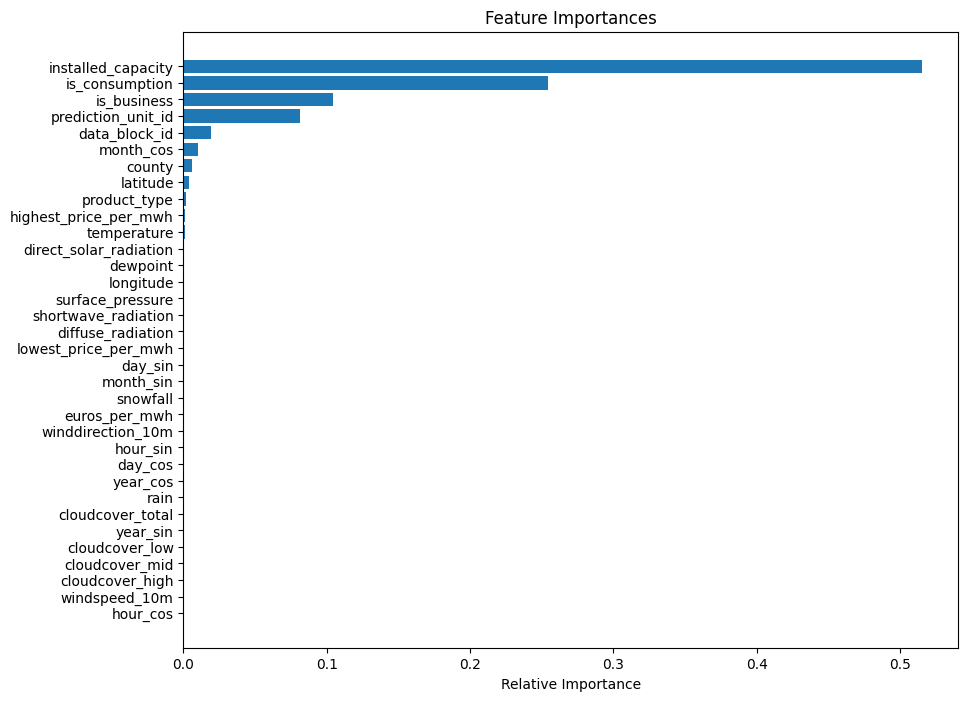

In [69]:
# Feature importances
feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
plt.xlabel("Relative Importance")
plt.show()


# Residual Analysis

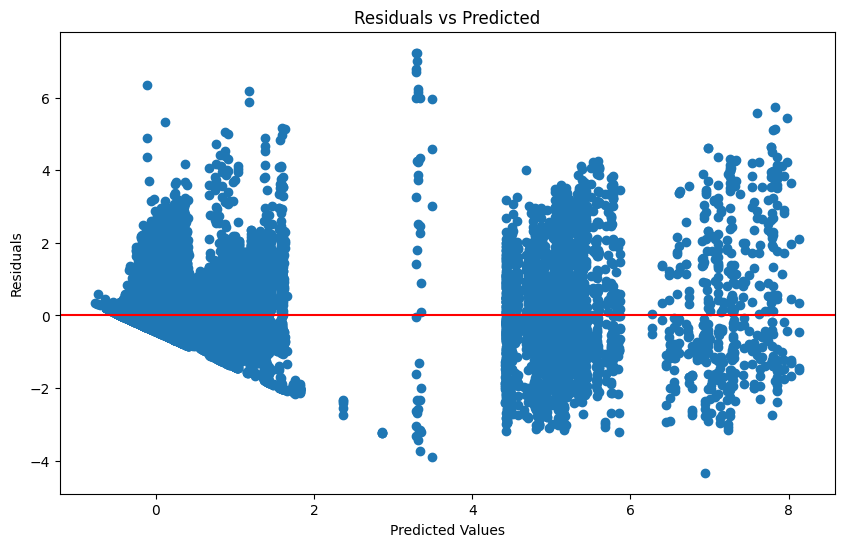

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure y_test and predictions are in the same format
y_test_series = y_test.squeeze()  
y_pred_series = pd.Series(y_pred, index=y_test.index)  

# Calculate residuals
residuals = y_test_series - y_pred_series

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_series, residuals)
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()



# Hyperparameter Tuning with Grid Search

In [66]:
from sklearn.model_selection import GridSearchCV

# Parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [4, 6, 8],
}

# Initialize the model
rf = RandomForestRegressor()

# Initialize Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2')

# Fit Grid Search
grid_search.fit(X_train, y_train.values.ravel())

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


/Users/gyeomi/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gyeomi/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/gyeomi/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove t

Best parameters: {'max_depth': 8, 'max_features': 'auto', 'n_estimators': 100}
Best score: 0.8506399967353739


# Build the Final Model with Optimal Parameters

In [75]:
# Creating the final model with the best parameters
final_model = RandomForestRegressor(max_depth=8, n_estimators=100, random_state=0)

# Fitting the model on the entire training set
final_model.fit(X_train, y_train.values.ravel())

# Predicting on the test set
final_predictions = final_model.predict(X_test)

# Evaluating the final model
final_r2_score = final_model.score(X_test, y_test)
print("Final Model R2 Score:", final_r2_score)


Final Model R2 Score: 0.8511322310926241


# Perform Final Evaluation

In [76]:
final_mae = mean_absolute_error(y_test, final_predictions)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print("Final Model Evaluation Metrics:")
print("Mean Absolute Error (MAE):", final_mae)
print("Mean Squared Error (MSE):", final_mse)
print("Root Mean Squared Error (RMSE):", final_rmse)


Final Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.1796417245441611
Mean Squared Error (MSE): 0.1483938799328048
Root Mean Squared Error (RMSE): 0.38521926215183583


# Feature Importance Analysis (Optional)

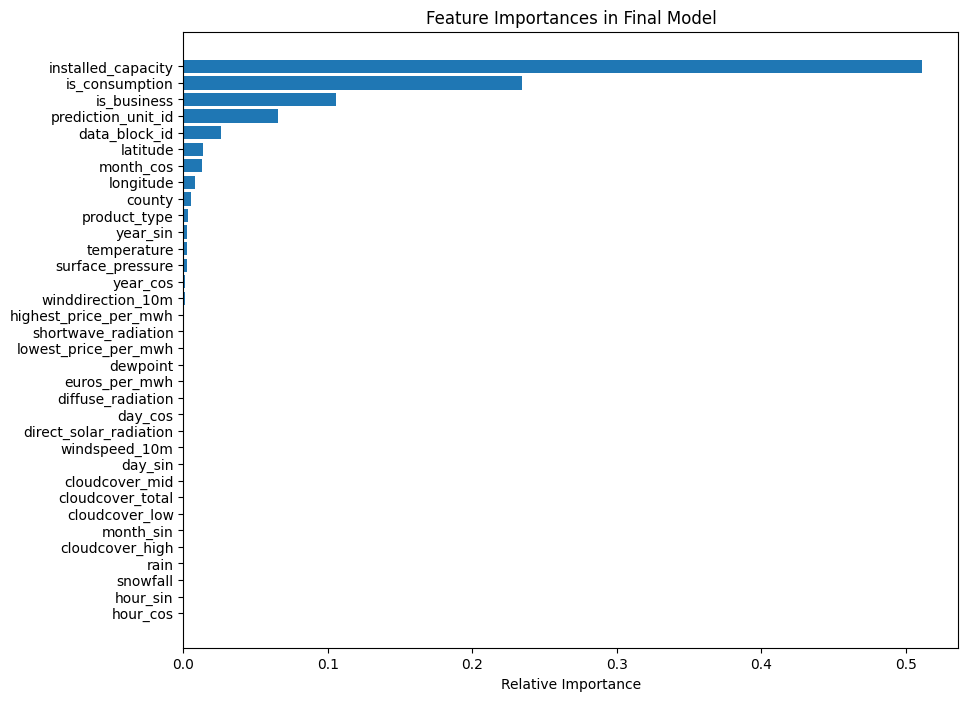

In [77]:
# Feature importances
final_feature_importance = final_model.feature_importances_
sorted_idx_final = np.argsort(final_feature_importance)

# Plot
plt.figure(figsize=(10, 8))
plt.title("Feature Importances in Final Model")
plt.barh(range(len(sorted_idx_final)), final_feature_importance[sorted_idx_final], align='center')
plt.yticks(range(len(sorted_idx_final)), [X.columns[i] for i in sorted_idx_final])
plt.xlabel("Relative Importance")
plt.show()
